In [1]:
#Import everything 
import matplotlib.pyplot as plt
import numpy as np

import ffmpeg_wrap
import signal_tools as st
import fft

import importlib
import hnt; importlib.reload(hnt)


import os
import shutil
import sys
import ffmpeg
from PIL import Image
import imagehash
import cv2
import torch
from torchvision import models, transforms
from scipy.signal import correlate
from scipy.spatial.distance import *
from fastdtw import fastdtw
from dtaidistance import dtw
from scipy.signal import savgol_filter
from scipy import signal

from scipy.fftpack import rfft, irfft, fftfreq, fft, ifft
from scipy.signal import butter, lfilter
from scipy.interpolate import interp1d

%matplotlib inline

plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams["figure.dpi"] = 150

**Settings**

In the following block a few settings can be chosen for the import of the video etc...

In [2]:
#Resolution of 2D signal (This can be small, to import it)
width_video = 50
height_video = int(width_video/1.77777)

br_fr = 24
vhs_fr = 25

skip_start_br = (60+20)*br_fr
skip_end_br = (60+56)*br_fr
# skip_end_br = 0

skip_start_vhs =(60+20)*vhs_fr
skip_end_vhs = (60+9)*vhs_fr
# skip_end_vhs = 0

video_shape = (width_video,height_video)

In [3]:
#Convert videos to 1D signal
# br_frames = hnt.import_2D_video_signal('F:/heidi_files/development/br.mkv',video_shape)
# vhs_frames = hnt.import_2D_video_signal('F:/heidi_files/development/vhs.mp4',video_shape)

# br_frames = hnt.import_2D_video_signal('F:/heidi_files/development/br_full.mkv',video_shape)
# vhs_frames = hnt.import_2D_video_signal('F:/heidi_files/development/vhs_full.mp4',video_shape)

br_frames = hnt.import_2D_video_signal('F:/heidi_files/development/b2.mkv',video_shape)
vhs_frames = hnt.import_2D_video_signal('F:/heidi_files/development/v2.mp4',video_shape)

print("Number of Blu-ray Frames before cuts: ",len(br_frames))
print("Number of VHS Frames before cuts: ",len(vhs_frames))

vhs_start_frames = vhs_frames[0:skip_start_vhs]

#skip start and end
br_frames = br_frames[skip_start_br: len(br_frames) - skip_end_br - 1]
vhs_frames = vhs_frames[skip_start_vhs: len(vhs_frames) - skip_end_vhs - 1]

print("Number of Blu-ray Frames after cuts: ",len(br_frames))
print("Number of VHS Frames after cuts: ",len(vhs_frames))

Number of Blu-ray Frames before cuts:  37125
Number of VHS Frames before cuts:  36018
Number of Blu-ray Frames after cuts:  32420
Number of VHS Frames after cuts:  32292


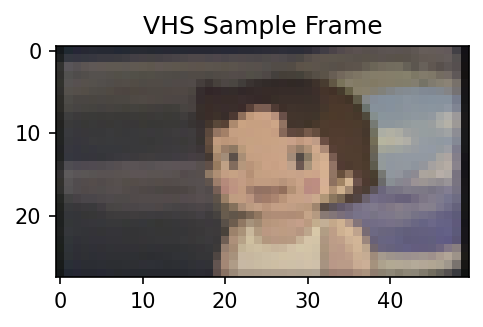

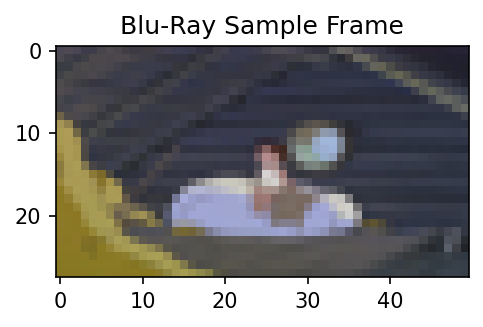

In [4]:
#Just a test to see if the video frames were correctly read
view_frame_num = 1000

plt.figure(figsize=(8,2))
plt.imshow(cv2.cvtColor(vhs_frames[view_frame_num], cv2.COLOR_YUV2RGB))
plt.title('VHS Sample Frame')
plt.show()  # Display the image

plt.figure(figsize=(8,2))
plt.imshow(cv2.cvtColor(br_frames[view_frame_num], cv2.COLOR_YUV2RGB))
plt.title('Blu-Ray Sample Frame')
plt.show()  # Display the image

Coverting video signal to one-dimentional array methods

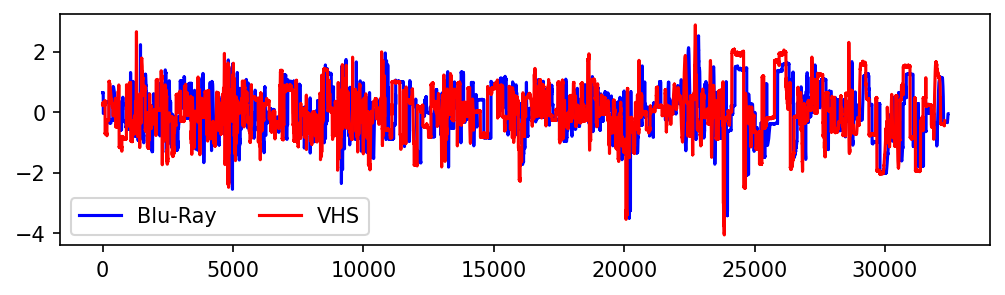

In [5]:
#Simon Blob
br_sig = hnt.convert_2_1D_signal_blob(br_frames,hnt.blob_generator(video_shape))
vhs_sig = hnt.convert_2_1D_signal_blob(vhs_frames,hnt.blob_generator(video_shape))

plt.figure(figsize=(8,2))
plt.plot(br_sig,color='b',label="Blu-Ray")
plt.plot(vhs_sig,color='r',label="VHS")
plt.legend(ncol=2)

#Comment: Looking good

Match the two signals - Mapping and correlations

In [6]:
# upx = 10
# lpow = roundint(2**np.ceil(np.log2(len(br_sig))))
# br_sig = signal.resample(np.r_[br_sig,np.zeros(lpow-len(br_sig))], lpow*upx)*1.0
#
# upx = 10
# lpow = roundint(2**np.ceil(np.log2(len(vhs_sig))))
# vhs_sig = signal.resample(np.r_[vhs_sig,np.zeros(lpow-len(vhs_sig))], lpow*upx)*1.0

In [7]:
print(len(br_sig))
print(len(vhs_sig))

32420
32292


In [8]:
x_shifted = np.roll(br_sig, hnt.normal_correlation(br_sig, vhs_sig))

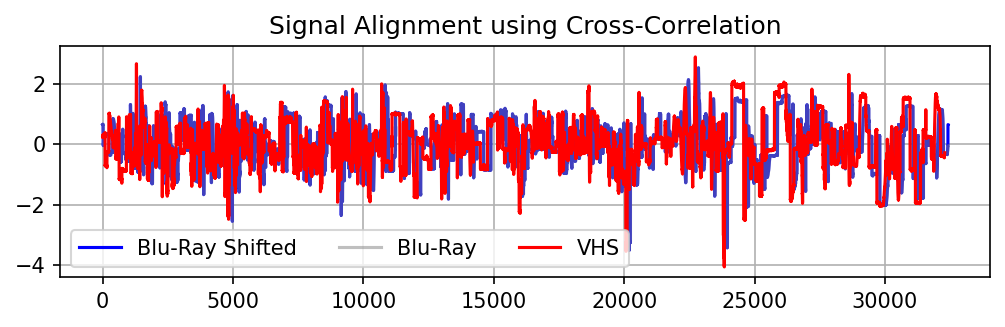

In [9]:
# Plotting
plt.figure(figsize=(8,2))
plt.plot(x_shifted,color='b',label="Blu-Ray Shifted")
plt.plot(br_sig,color='grey',label="Blu-Ray",alpha=0.5)
plt.plot(vhs_sig,color='r',label="VHS")
plt.legend(ncol=3)
plt.title('Signal Alignment using Cross-Correlation')
plt.grid(True)
random_point = 3000
# plt.xlim(random_point,random_point+500)
plt.show()

Simple slice correlation

In [10]:
def compute_delay_map_simple(sig1, sig2, nwindows=10, upsample=10):
    """
    Estimate a delay map between two signals using simple overlapping slices and normal cross correlation.

    Signal 1 = Blue Ray
    Signal 2 = VHS

    nwindows : int, optional | This is the number of equally spaced windows to use.
    """

    N = min(len(sig1), len(sig2))
    sig1 = sig1[:N]
    sig2 = sig2[:N]

    delay_map = np.zeros(N)
    weight = np.zeros(N)

    for i0, i1, dampwin in hnt.simple_slice_maker(N,int(N/nwindows)):
        slice1 = sig1[i0:i1]
        slice2 = sig2[i0:i1]

        delay = hnt.normal_correlation(slice1, slice2)

        delay_map[i0:i1] += delay
        weight[i0:i1] += 1

    # Normalize by count
    weight[weight == 0] = 1e-8 # make sure you don't device by 0
    return delay_map / weight

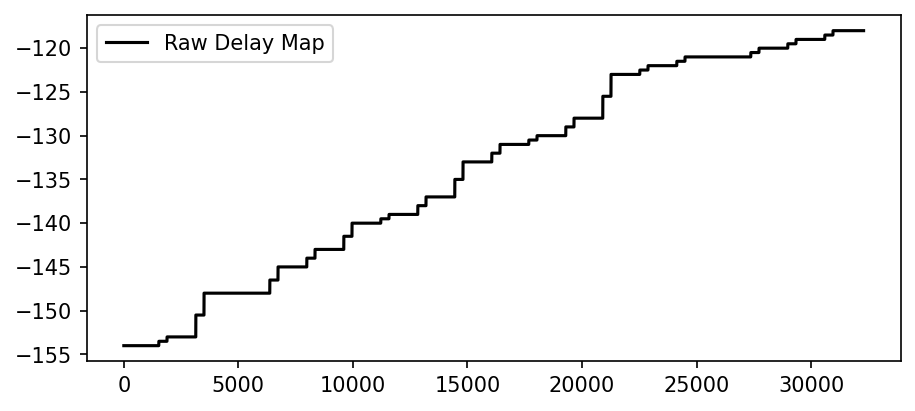

32292


In [11]:
delay_map_raw = compute_delay_map_simple(br_sig, vhs_sig, nwindows=18, upsample=10)

# delay_map = savgol_filter(delay_map_raw, window_length=51, polyorder=2)
# delay_map = hnt.bilateral_1d(delay_map_raw, sigma_spatial=10, sigma_intensity=0.1)

plt.plot(delay_map_raw,color="Black",label="Raw Delay Map")
# plt.plot(delay_map,color="Red",label="Filterd Delay_map")
plt.legend(ncol=2)
plt.show()

# Just a test to see if the video frames were correctly read
print(len(delay_map_raw))

# for i in range(0,len(vhs_sig),500):
#     plt.figure(figsize=(8,2))
#     plt.subplot(1, 2, 1)  # or plt.subplot(121)
#     plt.imshow(cv2.cvtColor(vhs_frames[i], cv2.COLOR_YUV2RGB))
#     plt.title('VHS Sample Frame')
#
#     plt.subplot(1, 2, 2)  # or plt.subplot(121)
#     plt.imshow(cv2.cvtColor(br_frames[i - int(delay_map_raw[i])], cv2.COLOR_YUV2RGB))
#     plt.title('Blu-Ray Sample Frame')
#     plt.show()  # Display the image


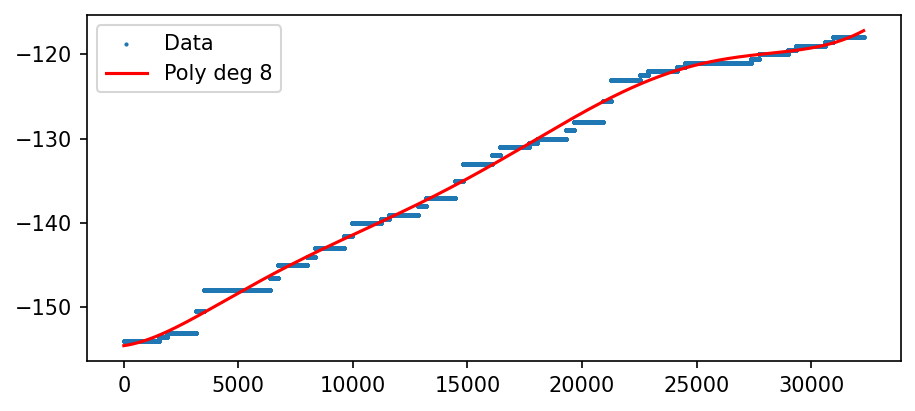

In [31]:
frame_axis = np.linspace(0,len(delay_map_raw),len(delay_map_raw))

degree = 8
coeffs = np.polyfit(frame_axis, delay_map_raw, degree)

# Create polynomial function
poly = np.poly1d(coeffs)

x_fit = np.linspace(min(frame_axis), max(frame_axis), 500)
y_fit = poly(frame_axis)

# Plot
plt.scatter(frame_axis, delay_map_raw, label="Data",s=1)
plt.plot(frame_axis, y_fit, color='red', label=f"Poly deg {degree}")
plt.legend()
plt.show()

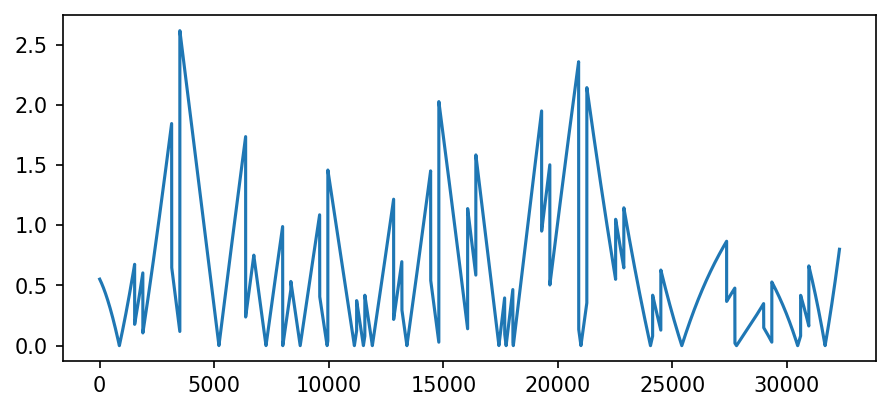

In [33]:
plt.plot(np.abs(y_fit-delay_map_raw))

In [12]:
br_frames_hd = hnt.import_2D_video_signal('F:/heidi_files/development/b2.mkv',(400,300))
br_frames_hd = br_frames_hd[skip_start_br: len(br_frames_hd) - skip_end_br - 1]

new_frames = []
for i in range(len(delay_map_raw) - 1):
    new_frames.append(cv2.cvtColor(br_frames_hd[i - int(delay_map_raw[i])], cv2.COLOR_YUV2BGR))

beggining_frames = []

for i in range(len(vhs_start_frames) - 1):
    beggining_frames.append(cv2.cvtColor(vhs_start_frames[i], cv2.COLOR_YUV2BGR))

In [13]:
final_frames = beggining_frames + new_frames

out = cv2.VideoWriter('F:/heidi_files/output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 25, (400, 300))

for frame in final_frames:
    # If using RGB images from matplotlib or PIL, convert to BGR for OpenCV:
    # frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame)

out.release()